<a href="https://colab.research.google.com/github/MattPlatt/test2/blob/main/S2GEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/S2gen

/content/drive/MyDrive/S2gen


In [ ]:
# Install Detectron2 (it includes Mask R-CNN)
!pip install torch torchvision torchaudio
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/detectron2.git
# Install Tesseract OCR and pytesseract in a single command
!apt-get update && apt-get install -y tesseract-ocr && pip install pytesseract


In [ ]:
import os
import cv2
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetMapper, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.model_zoo import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader




In [ ]:
# Import necessary libraries
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Paths to training and validation data
train_images_path = '/content/drive/MyDrive/S2gen/data/train/easy/images'
train_coco_annotations_file = '/content/drive/MyDrive/S2gen/data/train/easy/coco_annotations.json'
val_images_path = '/content/drive/MyDrive/S2gen/data/val/easy/images'
val_coco_annotations_file = '/content/drive/MyDrive/S2gen/data/val/easy/coco_annotations.json'

# Register the train and validation datasets
register_coco_instances("my_dataset_train", {}, train_coco_annotations_file, train_images_path)
register_coco_instances("my_dataset_val", {}, val_coco_annotations_file, val_images_path)

# Metadata for visualization (optional)
my_dataset_metadata = MetadataCatalog.get("my_dataset_train")


In [ ]:
import os
import cv2
import json
from detectron2.data import MetadataCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T

# Paths to images and COCO annotations file
images_path = '/content/drive/MyDrive/S2gen/data/train/easy/images'
coco_annotations_file = '/content/drive/MyDrive/S2gen/data/train/easy/coco_annotations.json'

# Register the dataset with COCO annotations
register_coco_instances("my_dataset", {}, coco_annotations_file, images_path)
my_dataset_metadata = MetadataCatalog.get("my_dataset")

# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset",)
cfg.DATASETS.TEST = ()  # No validation set for now
cfg.DATALOADER.NUM_WORKERS = 2

# Set to start training from scratch
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth'



# Training configurations
cfg.SOLVER.IMS_PER_BATCH = 1  # Adjust batch size based on memory
cfg.SOLVER.BASE_LR = 0.00001  # Set base learning rate
cfg.SOLVER.MAX_ITER = 5000  # Set max iterations for longer training

# ROI Heads configurations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # Regions per image in training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # Only one class, 'dashed_line'


# Ensure anchor generator settings match the training configuration
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

# Set input size for your images
cfg.INPUT.MIN_SIZE_TRAIN = 2176
cfg.INPUT.MAX_SIZE_TRAIN = 2752
cfg.INPUT.MIN_SIZE_TEST = 2176
cfg.INPUT.MAX_SIZE_TEST = 2752

# Set checkpoint saving every 500 iterations
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# Define output directory
cfg.OUTPUT_DIR = "/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer to include data augmentation
class AugmentedTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=DatasetMapper(
                cfg,
                is_train=True,
                augmentations=[
                    T.RandomBrightness(0.8, 1.2),
                    T.RandomContrast(0.8, 1.2),
                    T.RandomRotation(angle=[-10, 10]),  # Small rotations
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                ],
            ),
        )

# Initialize and start training with augmentations
trainer = AugmentedTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


In [ ]:
# import os
# import cv2
# import torch
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2 import model_zoo
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog

# # Path to the validation images and the output directory for predictions
# val_images_path = '/content/drive/MyDrive/S2gen/data/val/easy/images'
# predictions_path = '/content/drive/MyDrive/S2gen/runs/easy_predictions'
# os.makedirs(predictions_path, exist_ok=True)

# # Set up configuration for inference
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth'  # Path to your trained model
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set the threshold for detection
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9  # Number of classes in your dataset
# cfg.INPUT.MIN_SIZE_TEST = 2176
# cfg.INPUT.MAX_SIZE_TEST = 2752

# # Create a predictor
# predictor = DefaultPredictor(cfg)

# # Process each image in the validation folder
# for image_name in os.listdir(val_images_path):
#     if image_name.endswith((".jpg", ".png")):  # Only process image files
#         # Read the image
#         image_path = os.path.join(val_images_path, image_name)
#         image = cv2.imread(image_path)

#         # Run inference
#         outputs = predictor(image)

#         # Visualize the predictions on the image
#         v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#         v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

#         # Save the output image with predictions
#         output_image = v.get_image()[:, :, ::-1]  # Convert RGB back to BGR for OpenCV
#         output_path = os.path.join(predictions_path, image_name)
#         cv2.imwrite(output_path, output_image)

# print("Predictions saved in:", predictions_path)


In [ ]:
import os
import cv2
import json
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import MetadataCatalog, DatasetCatalog

# Define custom class names
custom_class_names = ["Block", "Connector", "Double Connector", "Call Out", "Double Box",
                      "Call Out Circle", "Dashed Line with Arrow", "Module", "Cables"]

# Function to return a list of dictionaries for the dataset (dummy implementation for registration)
def get_custom_dataset():
    return []

# Register the custom dataset
custom_dataset_name = "custom_val_dataset"
if custom_dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(custom_dataset_name)
    MetadataCatalog.remove(custom_dataset_name)

DatasetCatalog.register(custom_dataset_name, get_custom_dataset)
MetadataCatalog.get(custom_dataset_name).thing_classes = custom_class_names

# Paths
val_image_path = '/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png'
predictions_json_path_1 = '/content/drive/MyDrive/S2gen/runs/easy_predictions_1/predictions_1.json'
os.makedirs(os.path.dirname(predictions_json_path_1), exist_ok=True)

# Configure the first model
cfg1 = get_cfg()
cfg1.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg1.MODEL.WEIGHTS = '/content/drive/MyDrive/S2gen/runs/detect/MASK/easy/run1/model_final.pth'
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = len(custom_class_names)
cfg1.INPUT.MIN_SIZE_TEST = 2176
cfg1.INPUT.MAX_SIZE_TEST = 2752

# Set the dataset metadata for the custom dataset
cfg1.DATASETS.TRAIN = (custom_dataset_name,)
cfg1.DATASETS.TEST = (custom_dataset_name,)

# Create predictor and load image
predictor1 = DefaultPredictor(cfg1)
image = cv2.imread(val_image_path)

# Run inference
outputs1 = predictor1(image)

# Prepare COCO-style JSON output
coco_annotations_1 = {
    "images": [{"file_name": os.path.basename(val_image_path), "height": image.shape[0], "width": image.shape[1], "id": 1}],
    "annotations": [],
    "categories": [{"id": i, "name": name} for i, name in enumerate(custom_class_names)]
}

# Convert Detectron2 predictions to COCO-style format
instances = outputs1["instances"].to("cpu")
for i in range(len(instances)):
    bbox = instances.pred_boxes[i].tensor.numpy().tolist()[0]
    category_id = int(instances.pred_classes[i].item())
    coco_annotations_1["annotations"].append({
        "id": i,
        "image_id": 1,
        "category_id": category_id,
        "bbox": [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],  # Convert to COCO bbox format
        "area": float((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])),
        "iscrowd": 0
    })

# Save the JSON file for the first model's predictions
with open(predictions_json_path_1, 'w') as f:
    json.dump(coco_annotations_1, f)

print(f"First model predictions saved in COCO JSON format at: {predictions_json_path_1}")


In [ ]:
import os
import cv2
import json
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from pycocotools import mask as mask_utils
import numpy as np

# Directory setup for sliced images and JSON output for the second model
sliced_images_folder = '/content/drive/MyDrive/S2gen/data/val/easy/sliced_images'
predictions_json_path_2 = '/content/drive/MyDrive/S2gen/runs/easy_predictions_2/predictions_2.json'
os.makedirs(sliced_images_folder, exist_ok=True)
os.makedirs(os.path.dirname(predictions_json_path_2), exist_ok=True)

# Slicing parameters
slice_width, slice_height = 550, 435
num_slices_width, num_slices_height = 7, 6
overlap_percentage_width, overlap_percentage_height = 0.25, 0.25

# Configure the second model
cfg2 = get_cfg()
cfg2.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg2.MODEL.WEIGHTS = "/content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run2_scratch/model_0019999.pth"
cfg2.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg2.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class, 'Cables'
cfg2.INPUT.MIN_SIZE_TEST = 435
cfg2.INPUT.MAX_SIZE_TEST = 550

# Ensure anchor generator settings match the training configuration
cfg2.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
cfg2.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

predictor2 = DefaultPredictor(cfg2)

# COCO-style JSON output for second model with category ID set for 'Cables'
coco_annotations_2 = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 8, "name": "Cable"}]  # Set category ID to 8 for 'Cables'
}

# Load the image and prepare slicing
image = cv2.imread(val_image_path)
original_height, original_width, _ = image.shape
step_width = int(slice_width * (1 - overlap_percentage_width))
step_height = int(slice_height * (1 - overlap_percentage_height))
annotation_id = 0

# Slice the image and run inference on each slice
for i in range(num_slices_height):
    for j in range(num_slices_width):
        x_start = j * step_width
        y_start = i * step_height
        x_end = min(x_start + slice_width, original_width)
        y_end = min(y_start + slice_height, original_height)

        # Slice and save image
        slice_img = image[y_start:y_end, x_start:x_end]
        slice_name = f"diagram_8001_{i}_{j}.png"
        slice_path = os.path.join(sliced_images_folder, slice_name)
        cv2.imwrite(slice_path, slice_img)

        # Run inference on the slice
        outputs2 = predictor2(slice_img)
        instances = outputs2["instances"].to("cpu")

        # Add slice info to JSON with a unique image_id for each slice
        image_id = i * num_slices_width + j + 1  # Unique ID for each slice
        coco_annotations_2["images"].append({
            "file_name": slice_name,
            "height": slice_img.shape[0],
            "width": slice_img.shape[1],
            "id": image_id
        })

        # Convert predictions to COCO-style annotations with adjusted coordinates
        for k in range(len(instances)):
            bbox = instances.pred_boxes[k].tensor.numpy().tolist()[0]
            mask = instances.pred_masks[k].numpy()
            encoded_mask = mask_utils.encode(np.asfortranarray(mask.astype(np.uint8)))
            encoded_mask["counts"] = encoded_mask["counts"].decode("utf-8")

            # Adjust bbox position to map to original image coordinates
            adjusted_bbox = [
                bbox[0] + x_start,  # Adjust x coordinate to full image
                bbox[1] + y_start,  # Adjust y coordinate to full image
                bbox[2] - bbox[0],  # Width remains the same
                bbox[3] - bbox[1]   # Height remains the same
            ]

            # Add adjusted annotations to the JSON
            coco_annotations_2["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,  # Correct unique image_id for each slice
                "category_id": 8,  # Set category_id to 8 for 'Cables'
                "bbox": adjusted_bbox,
                "segmentation": encoded_mask,
                "area": float(mask.sum()),
                "iscrowd": 0
            })
            annotation_id += 1

# Save JSON file for the second model's predictions
with open(predictions_json_path_2, 'w') as f:
    json.dump(coco_annotations_2, f)

print(f"Second model predictions saved in COCO JSON format at: {predictions_json_path_2}")


In [ ]:
import json

# Load both JSON files
with open(predictions_json_path_1, 'r') as f1:
    coco_annotations_1 = json.load(f1)

with open(predictions_json_path_2, 'r') as f2:
    coco_annotations_2 = json.load(f2)

# Combine annotations and images
combined_annotations = {
    "images": coco_annotations_1["images"],  # Use the original image info
    "annotations": coco_annotations_1["annotations"] + coco_annotations_2["annotations"],
    "categories": coco_annotations_1["categories"]
}

# Save the combined JSON file
combined_json_path = "/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json"
os.makedirs(os.path.dirname(combined_json_path), exist_ok=True)
with open(combined_json_path, 'w') as f:
    json.dump(combined_annotations, f)

print(f"Combined predictions saved in COCO JSON format at: {combined_json_path}")


In [ ]:
import os
import cv2
import json
import numpy as np
from pycocotools import mask as mask_utils

# Paths
original_image_path = '/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png'
combined_json_path = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json'
output_dir = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/annotated_image'
os.makedirs(output_dir, exist_ok=True)

# Load the original image
original_image = cv2.imread(original_image_path)

# Load combined predictions
with open(combined_json_path, 'r') as f:
    combined_predictions = json.load(f)

# Overlay each annotation on the original image
for annotation in combined_predictions['annotations']:
    # Get the bounding box and category
    bbox = annotation['bbox']
    x_start, y_start, width, height = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
    category_id = annotation['category_id']

    # Draw the bounding box
    color = (0, 255, 0)  # Green for bounding boxes
    cv2.rectangle(original_image, (x_start, y_start), (x_start + width, y_start + height), color, 2)

    # Draw the category label above the bounding box
    label = combined_predictions['categories'][category_id]['name']
    cv2.putText(original_image, label, (x_start, y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Draw segmentation mask if available
    if 'segmentation' in annotation:
        segmentation = annotation['segmentation']
        if isinstance(segmentation, dict):  # RLE format
            mask = mask_utils.decode(segmentation).astype(np.uint8) * 255  # Decode the RLE mask
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(original_image, contours, -1, (255, 0, 0), 2)  # Blue for masks
        elif isinstance(segmentation, list):  # Polygon format
            for seg in segmentation:
                poly = np.array(seg).reshape((-1, 2)).astype(np.int32)
                cv2.polylines(original_image, [poly], isClosed=True, color=(255, 0, 0), thickness=2)

# Save the annotated image
output_image_path = os.path.join(output_dir, 'diagram_8001_annotated.png')
cv2.imwrite(output_image_path, original_image)

print(f"Annotated image saved at: {output_image_path}")


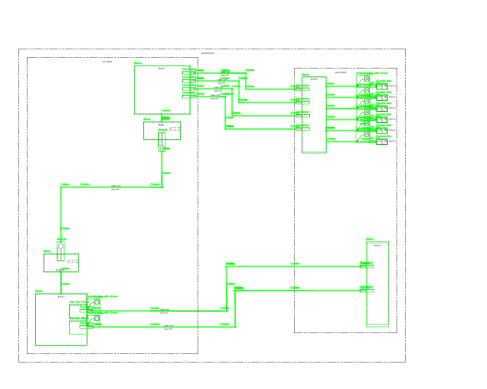

In [4]:
import matplotlib.pyplot as plt
import cv2

# Load an image using OpenCV (use the correct path to your image)
image = cv2.imread('/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/annotated_image/diagram_8001_annotated.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
import json
import cv2
import numpy as np
import pytesseract

# Load the combined predictions JSON file
combined_json_path = '/content/drive/MyDrive/S2gen/runs/easy_predictions_combined/predictions_combined.json'
with open(combined_json_path, 'r') as f:
    predictions = json.load(f)

# Load the image to extract text from blocks
image_path = "/content/drive/MyDrive/S2gen/data/val/easy/diagram_8001.png"  # Update with the correct path
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

import cv2
import pytesseract
import numpy as np

import cv2
import pytesseract
import numpy as np

import cv2
import pytesseract
import numpy as np

def extract_text_from_bbox(image, bbox):
    # Use the full bounding box dimensions
    x, y, w, h = map(int, bbox)

    # Focus only on the top 20% of the bounding box
    top_section_height = int(h * 0.2)
    cropped_image = image[y:y + top_section_height, x:x + w]

    # Convert to grayscale
    gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

    # Apply resizing (magnification) to enhance OCR performance
    magnified_image = cv2.resize(gray, None, fx=4.0, fy=4.0, interpolation=cv2.INTER_CUBIC)

    # Apply adaptive thresholding to improve text clarity
    thresh = cv2.adaptiveThreshold(magnified_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # OCR configuration focused on capturing single lines or words
    custom_config = r'--psm 7 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-'
    text = pytesseract.image_to_string(thresh, config=custom_config).strip()

    return text



# Initialize SysML part definitions and interface connections
block_parts = []
module_parts = []
connector_parts = []
cable_parts = []
interface_connections = []

# Define mappings for category IDs to names (use class names from your model)
category_id_to_name = {
    0: 'Block',
    1: 'Connector',
    2: 'Double Connector',
    3: 'Cable',
    4: 'Dashed Line with Arrow',
    5: 'Module',
    6: 'Double Box',
    7: 'Call Out',
    8: 'Cables',
    9: 'Double Connector',
    10: 'Call Out Circle',
}

# Organize parts based on categories
for annotation in predictions["annotations"]:
    category_name = category_id_to_name.get(annotation["category_id"], None)
    part_id = f"{category_name.lower()}{annotation['id']}"

    if category_name == "Block":
        # Extract text only for blocks
        block_name = extract_text_from_bbox(image, annotation["bbox"])
        block_parts.append(f"part {part_id}: Block {{ attribute name = \"{block_name}\"; }}")
    elif category_name == "Module":
        module_parts.append(f"part {part_id}: Module;")
    elif category_name == "Connector":
        connector_parts.append(f"part {part_id}: Connector;")
    elif category_name == "Cable":
        cable_parts.append(f"part {part_id}: Cable {{ attribute id = {annotation['id']}; }};")

# Generate connections based on SysML rules
def boxes_touch(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    return not (x1 + w1 < x2 or x2 + w2 < x1 or y1 + h1 < y2 or y2 + h2 < y1)

for cable in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Cable"]:
    for other_cable in [ann for ann in predictions["annotations"] if ann["id"] != cable["id"] and category_id_to_name.get(ann["category_id"]) == "Cable"]:
        if boxes_touch(cable["bbox"], other_cable["bbox"]):
            interface_connections.append(f"interface sameCableConnection: BinaryInterface connect cable{cable['id']} to cable{other_cable['id']} using Cable;")

    for connector in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Connector"]:
        if boxes_touch(cable["bbox"], connector["bbox"]):
            interface_connections.append(f"interface cableConnectorConnection: BinaryInterface connect cable{cable['id']} to connector{connector['id']} using Cable;")

for connector in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Connector"]:
    for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
        if boxes_touch(connector["bbox"], block["bbox"]):
            interface_connections.append(f"interface blockConnectorConnection: BinaryInterface connect connector{connector['id']} to block{block['id']} using Connector;")

    for module in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Module"]:
        if boxes_touch(connector["bbox"], module["bbox"]):
            interface_connections.append(f"interface moduleConnectorConnection: BinaryInterface connect connector{connector['id']} to module{module['id']} using Connector;")

for module in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Module"]:
    for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
        if boxes_touch(module["bbox"], block["bbox"]):
            interface_connections.append(f"interface moduleBlockConnection: BinaryInterface connect module{module['id']} to block{block['id']} using Module;")

for dashed_line in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Dashed Line with Arrow"]:
    for cable in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Cable"]:
        combined_bbox = [
            min(dashed_line["bbox"][0], cable["bbox"][0]),
            min(dashed_line["bbox"][1], cable["bbox"][1]),
            max(dashed_line["bbox"][2] + dashed_line["bbox"][0], cable["bbox"][2] + cable["bbox"][0]) - min(dashed_line["bbox"][0], cable["bbox"][0]),
            max(dashed_line["bbox"][3] + dashed_line["bbox"][1], cable["bbox"][3] + cable["bbox"][1]) - min(dashed_line["bbox"][1], cable["bbox"][1])
        ]

        for block in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Block"]:
            if boxes_touch(combined_bbox, block["bbox"]):
                interface_connections.append(f"interface dashedLineBlockConnection: BinaryInterface connect dashedlinewitharrow{dashed_line['id']} to block{block['id']} using DashedLineWithArrow;")

    for double_box in [ann for ann in predictions["annotations"] if category_id_to_name.get(ann["category_id"]) == "Double Box"]:
        if boxes_touch(dashed_line["bbox"], double_box["bbox"]):
            interface_connections.append(f"interface dashedLineDoubleBoxConnection: BinaryInterface connect dashedlinewitharrow{dashed_line['id']} to doublebox{double_box['id']} using DashedLineWithArrow;")

# Compile SysML code
sysml_code = "package ConnectionExample {\n\n"
sysml_code += "    // Part definitions for Blocks, Modules, Connectors, and Cables\n"
sysml_code += "    " + "\n    ".join(block_parts + module_parts) + "\n\n"
sysml_code += "    // Connector definitions\n"
sysml_code += "    " + "\n    ".join(connector_parts) + "\n\n"
sysml_code += "    // Cable parts with unique identifiers\n"
sysml_code += "    " + "\n    ".join(cable_parts) + "\n\n"
sysml_code += "    // Interface definitions for connections between parts\n"
sysml_code += "    " + "\n    ".join(interface_connections) + "\n\n"
sysml_code += "}\n"

# Save SysML output to a file
sysml_output_path = '/content/drive/MyDrive/S2gen/runs/easy_sysml2_output.txt'
with open(sysml_output_path, 'w') as f:
    f.write(sysml_code)

print(f"SysML code saved at: {sysml_output_path}")


In [ ]:
# import cv2
# import os
# from detectron2.engine import DefaultPredictor
# from detectron2.config import get_cfg
# from detectron2 import model_zoo
# from detectron2.utils.visualizer import Visualizer
# from detectron2.data import MetadataCatalog

# # Configure model
# cfg = get_cfg()
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/S2gen/runs/detect/MASK/r101_run2_scratch/model_0019999.pth"
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # Lower threshold to capture more predictions
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class, 'dashed_line'

# # Ensure anchor generator settings match the training configuration
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8], [16], [32], [64], [128]]
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.05, 0.1, 0.2, 0.3]]

# # Initialize the predictor
# predictor = DefaultPredictor(cfg)

# # Path for the test image
# image_path = '/content/drive/MyDrive/S2gen/data/val/easy/sliced_images/diagram_8001_5_3.png'
# image = cv2.imread(image_path)

# # Run prediction
# outputs = predictor(image)
# instances = outputs["instances"].to("cpu")

# # Print results for debugging
# print(f"Detected instances: {len(instances)}")
# if len(instances) > 0:
#     print("Classes:", instances.pred_classes)
#     print("Scores:", instances.scores)
#     print("Bounding Boxes:", instances.pred_boxes)

# # Visualize predictions on the image
# v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
# v = v.draw_instance_predictions(instances)
# output_image = v.get_image()[:, :, ::-1]

# # Directory to save the visualization
# output_dir = "/content/drive/MyDrive/S2gen/runs/prediction_results"
# os.makedirs(output_dir, exist_ok=True)

# # Save the visualized image
# output_image_path = os.path.join(output_dir, "diagram_8001_5_3_pred.png")
# cv2.imwrite(output_image_path, output_image)
# print(f"Predicted image saved to {output_image_path}")
